In [2]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def get_data(symbol, interval='1d', start_date=None, end_date=None, limit=1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    if start_date:
        url += f'&startTime={int(pd.Timestamp(start_date).timestamp() * 1000)}'
    if end_date:
        url += f'&endTime={int(pd.Timestamp(end_date).timestamp() * 1000)}'
    
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f'Error fetching data: {response.status_code} - {response.text}')
    
    data = response.json()
    columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 
               'Close Time', 'Quote Asset Volume', 'Number of Trades', 
               'Taker Buy Base Volume', 'Taker Buy Quote Volume', 'Ignore']
    
    df = pd.DataFrame(data, columns=columns)
    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df['Close'] = df['Close'].astype(float)
    return df[['Open Time', 'Close']]

btc_data = get_data('BTCUSDT', interval='1d', start_date='2023-03-01', end_date='2025-02-05')


In [3]:
scaled_data = btc_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(scaled_data)

# Sliding Window Parameters
time_step = 5

# Create features (X) and labels (y)
X, y = [], []
for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i - time_step:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1])  

In [5]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse Transform Predictions
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [19]:
# Parameters
prediction_ahead = 15  # 
time_step = 5          # Same as used during training

# Use the last 'time_step' data points as the initial input
last_known_data = scaled_data[-time_step:].reshape(1, time_step)  # Shape: (1, time_step)

print(last_known_data)



[[0.93594639 0.90181506 0.94400367 0.90254233 0.89986165]]


In [18]:
# List to store future predictions
future_forecast = []

# Recursive Forecasting for 15 Days
for _ in range(prediction_ahead):
    # Predict the next value
    next_prediction = model.predict(last_known_data)[0]  # Shape: (1,)

    future_forecast.append(next_prediction)
    
    # Reshape next_prediction to match dimensions (1, time_step)
    next_prediction = next_prediction.reshape(1, -1)  # Shape: (1, 1)

    last_known_data = np.concatenate((last_known_data[:, 1:], next_prediction), axis=1)

# Inverse Transform to get actual price values
future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Generate future dates for plotting
future_dates = pd.date_range(start=btc_data['Open Time'].iloc[-1] + pd.Timedelta(days=1), 
                             periods=prediction_ahead, freq='D')

# Display the predicted prices
for date, price in zip(future_dates, future_forecast):
    print(f"{date.date()}: ${price[0]:.2f}")


2025-02-06: $97193.50
2025-02-07: $97154.12
2025-02-08: $96947.82
2025-02-09: $96836.49
2025-02-10: $96705.98
2025-02-11: $96588.17
2025-02-12: $96465.52
2025-02-13: $96346.21
2025-02-14: $96226.42
2025-02-15: $96107.51
2025-02-16: $95988.84
2025-02-17: $95870.69
2025-02-18: $95752.93
2025-02-19: $95635.60
2025-02-20: $95518.68


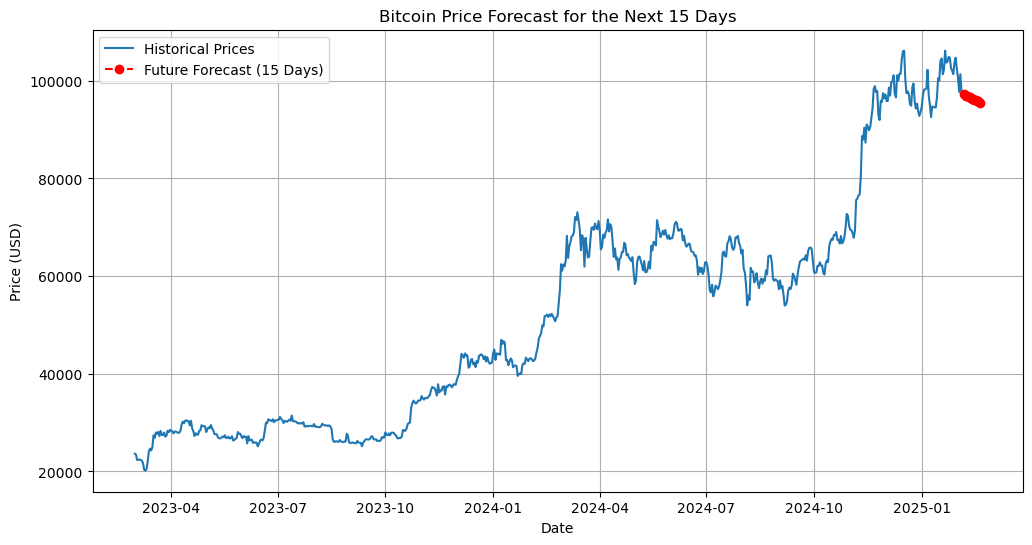

In [16]:

# Plotting the future forecast
plt.figure(figsize=(12, 6))
plt.plot(btc_data['Open Time'], btc_data['Close'], label='Historical Prices')
plt.plot(future_dates, future_forecast, marker='o', linestyle='--', color='red', label='Future Forecast (15 Days)')

plt.title('Bitcoin Price Forecast for the Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()
